# News Headlines Sentiment Analysis to Evaluate Tweets

Note: real news = 0, fake news = 1

In [1]:
import nltk
import string

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import plotly.express    as px

from matplotlib import cm
from tqdm       import tqdm
from wordcloud  import WordCloud

from nltk.probability import FreqDist
from nltk.corpus      import stopwords
from nltk.tokenize    import sent_tokenize, word_tokenize
from nltk.stem        import PorterStemmer, WordNetLemmatizer

from imblearn.combine        import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline       import Pipeline

from sklearn          import metrics
from sklearn.metrics  import confusion_matrix, plot_confusion_matrix, classification_report, make_scorer, accuracy_score
from sklearn.datasets import make_classification

from sklearn.preprocessing           import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection         import train_test_split, GridSearchCV
from sklearn.model_selection         import cross_validate, RepeatedStratifiedKFold

from sklearn.naive_bayes   import MultinomialNB, GaussianNB
from sklearn.ensemble      import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble      import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.svm           import SVC

np.random.seed(0)

## Combining All Datasets

In [2]:
esocinfo = pd.read_csv('Data/Headlines/ESOCheadlines_eng.csv')
zenodoinfo = pd.read_csv('Data/Headlines/Zenodoheadlines.csv')
fakeinfo = pd.read_csv('Data/Headlines/fakeheadlines.csv')
trueinfo = pd.read_csv('Data/Headlines/trueheadlines.csv')
sarcasminfo = pd.read_csv('Data/Headlines/sarc_headlines.csv')

In [3]:
df = pd.concat([esocinfo, zenodoinfo, fakeinfo, trueinfo, sarcasminfo], ignore_index=True)
#shape: (111928, 2)

In [4]:
df.real_or_fake.value_counts()

0    61114
1    50814
Name: real_or_fake, dtype: int64

## Data Instantiation and Lemmatization

In [5]:
data = df['headline']
target = df['real_or_fake']

processed_data = [d.split() for d in data.to_list()]

lemmatizer = WordNetLemmatizer()
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

### Lemmatized Data

In [6]:
X_lem = lemmatized_output
y_lem = target

## Stop Words List

In [7]:
sw_list  = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', '27', '1', "'ve",
            '-', '–', '—', "n't", 'https', '2', "'re", "'m'", '3', '..', 'ca', "'s", 'amp']

## TFIDF Vectorization
### Keeping all rows but Maximum Features after vectorization: 5000

In [8]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)

tfidf = TfidfVectorizer(stop_words=sw_list, max_features=5000)
tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem  = tfidf.transform(X_test_lem)
#shape train: (89542, 5000)
#shape test: (22386, 5000)

#### Average Number Of Elements And Matrix Sparsity

In [9]:
non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Text: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Text: 6.913180406959863
Percentage of columns containing ZERO: 0.998617363918608


### Dense Data

In [9]:
train = tfidf_data_train_lem.toarray()
test  = tfidf_data_test_lem.toarray()

### Data Seperability
#### PCA Transformation

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train)
X_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca['Target'] = y_lem

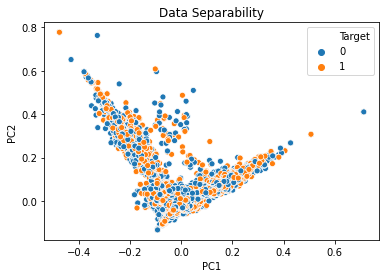

In [14]:
sns.scatterplot(x=X_pca['PC1'], y=X_pca['PC2'],
                hue=X_pca['Target']).set_title('Data Separability');

## SMOTETomek Data
SMOTETomek data created from 89542 rows OR about 80% of the total dataset

In [10]:
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_res, y_res = resample.fit_resample(tfidf_data_train_lem, y_train_lem)

In [11]:
X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_res, y_res, test_size=0.20, random_state=1)
#shape X_res_train: (78076, 5000)
#shape X_res_test: (19520, 5000)

### SMOTETomek Dense Data

In [12]:
train_res = X_res_train.toarray()
test_res = X_res_test.toarray()

# Base Models

## Gausian Naive Bayes - all data

In [17]:
gnb = GaussianNB()

gnb.fit(train, y_train_lem)

gnb_train_preds_lem = gnb.predict(train)
gnb_test_preds_lem  = gnb.predict(test)

print(classification_report(y_train_lem, gnb_train_preds_lem))
print(classification_report(y_test_lem, gnb_test_preds_lem))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82     48932
           1       0.80      0.72      0.76     40610

    accuracy                           0.79     89542
   macro avg       0.79      0.79      0.79     89542
weighted avg       0.79      0.79      0.79     89542

              precision    recall  f1-score   support

           0       0.77      0.84      0.80     12182
           1       0.78      0.70      0.74     10204

    accuracy                           0.77     22386
   macro avg       0.78      0.77      0.77     22386
weighted avg       0.77      0.77      0.77     22386



## Gausian Naive Bayes - SMOTETomek data
NOTE: SMOTETomek data has 78076 rows i.e. about 70% of the total dataset

In [47]:
gnb_smote = GaussianNB()

gnb_smote.fit(train, y_train_lem)

gnb_smote_train_preds = gnb.predict(train_res)
gnb_smote_test_preds  = gnb.predict(test_res)

print(classification_report(y_res_train, gnb_smote_train_preds))
print(classification_report(y_res_test, gnb_smote_test_preds))

              precision    recall  f1-score   support

           0       0.73      0.85      0.79     38865
           1       0.82      0.68      0.75     39211

    accuracy                           0.77     78076
   macro avg       0.78      0.77      0.77     78076
weighted avg       0.78      0.77      0.77     78076

              precision    recall  f1-score   support

           0       0.74      0.85      0.79      9799
           1       0.83      0.69      0.75      9721

    accuracy                           0.77     19520
   macro avg       0.78      0.77      0.77     19520
weighted avg       0.78      0.77      0.77     19520



## Random Forest Classifier - all data

In [14]:
rf = RandomForestClassifier(random_state=123)

rf.fit(train, y_train_lem)

rf_train_preds_lem = rf.predict(train)
rf_test_preds_lem = rf.predict(test)

print(classification_report(y_train_lem, rf_train_preds_lem))
print(classification_report(y_test_lem, rf_test_preds_lem))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48932
           1       1.00      1.00      1.00     40610

    accuracy                           1.00     89542
   macro avg       1.00      1.00      1.00     89542
weighted avg       1.00      1.00      1.00     89542

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     12182
           1       0.93      0.88      0.91     10204

    accuracy                           0.92     22386
   macro avg       0.92      0.92      0.92     22386
weighted avg       0.92      0.92      0.92     22386



## Random Forest Classifier - SMOTETomek data 
NOTE: SMOTETomek data has 78076 rows i.e. about 70% of the total dataset

In [50]:
rf_smote = RandomForestClassifier(random_state=123)

rf_smote.fit(train_res, y_res_train)

rf_smote_train_preds = rf.predict(train_res)
rf_smote_test_preds = rf.predict(test_res)

print(classification_report(y_res_train, rf_smote_train_preds))
print(classification_report(y_res_test, rf_smote_test_preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     38865
           1       1.00      0.95      0.97     39211

    accuracy                           0.97     78076
   macro avg       0.97      0.97      0.97     78076
weighted avg       0.97      0.97      0.97     78076

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      9799
           1       1.00      0.95      0.97      9721

    accuracy                           0.97     19520
   macro avg       0.97      0.97      0.97     19520
weighted avg       0.97      0.97      0.97     19520



## Support Vector Machine
This model was originally run in another notebook, entitled models_all_data.ipynb. An image of the code and resulting classification report is seen below as this model has a very high computational cost - it took two days to run.

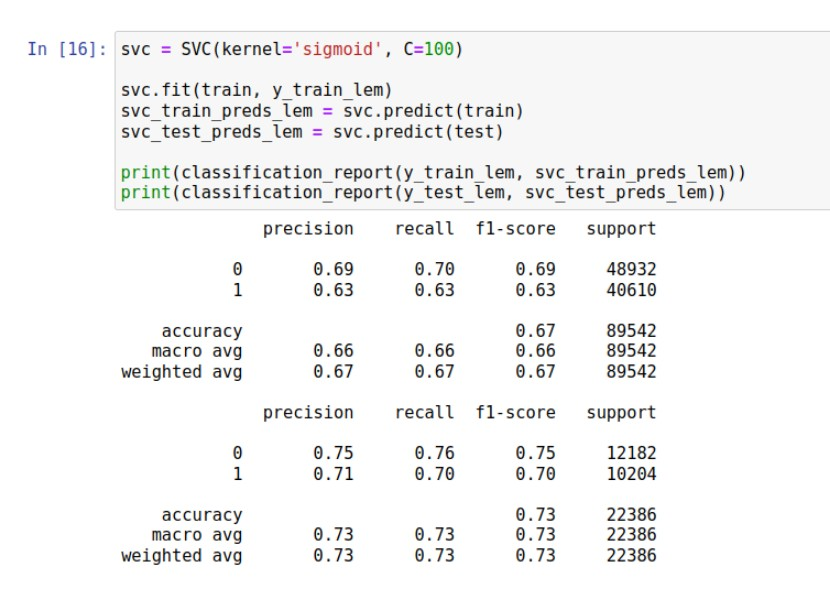

# GridSearch 
Due to the size of the dataset, in order to run an exhaustive GridSearch for Gaussian Naive Bayes and Random Forest Classifier models, a subset of 10,000 rows of the full dataset was implemented.

## Gaussian Naive Bayes GridSearch - SMOTETomek data 
NOTE: SMOTETomek data has 78076 rows i.e. about 70% of the total dataset

In [ ]:
gnb_params = {'var_smoothing': np.logspace(0,-9,num=100)}

gnb_smote_grid = GridSearchCV(estimator=GaussianNB(), param_grid=gnb_params, verbose=1, cv=5, n_jobs=-1)

gnb_smote_grid.fit(train_res, y_res_train)

gnb_smote_grid_train_preds = gnb_smote_grid.predict(train_res)
gnb_smote_grid_test_preds = gnb_smote_grid.predict(test_res)

print('\033[1m' + 'Gaussian Naive Bayes Train Report:\n' + '\033[0m')
print(classification_report(y_res_train, gnb_smote_grid_train_preds))
print('\033[1m' + 'Gaussian Naive Bayes Test Report:\n' + '\033[0m')
print(classification_report(y_res_test, gnb_smote_grid_test_preds))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
print('\033[1m' + 'Gaussian Naive Bayes Train Data Confusion Matrix:\n')
plot_confusion_matrix(gnb_smote_grid, train_res, y_res_train, cmap=plt.cm.Blues)
plt.show()
print('\033[1m' + 'Gaussian Naive Bayes Test Data Confusion Matrix:\n')
plot_confusion_matrix(gnb_smote_grid, test_res, y_res_test, cmap=plt.cm.Blues)
plt.show()

## Random Forest GridSearch - SMOTETomek data 
NOTE: SMOTETomek data has 78076 rows i.e. about 70% of the total dataset

In [ ]:
rf_params = {'n_estimators': [100,200], 'criterion':['gini', 'entropy'],
           'oob_score':['True', 'False'], 'max_depth':[10,15,20]}

rf_smote_grid = GridSearchCV(RandomForestClassifier(), rf_params, scoring='f1_weighted',
                      return_train_score=True, verbose=1, n_jobs=-1)

rf_smote_grid.fit(train_res, y_res_train)

rf_smote_grid_train_preds = rf_smote_grid.predict(train_res)
rf_smote_grid_test_preds = rf_smote_grid.predict(test_res)

print('\033[1m' + 'Random Forest Classifier Train Report:\n' + '\033[0m')
print(classification_report(y_res_train, rf_smote_grid_train_preds))
print('\033[1m' + 'Random Forest Classifier Test Report:\n' + '\033[0m')
print(classification_report(y_res_test, rf_smote_grid_test_preds))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
print('\033[1m' + 'Random Forest Classifier Train Data Confusion Matrix:\n')
plot_confusion_matrix(rf_smote_grid, train_res, y_res_train, cmap=plt.cm.Blues)
plt.show()
print('\033[1m' + 'Random Forest Classifier Test Data Confusion Matrix:\n')
plot_confusion_matrix(rf_smote_grid, test_res, y_res_test, cmap=plt.cm.Blues)
plt.show()

### Sample of 10000 Rows of the All Headlines Dataset

In [16]:
df_sample10 = df.sample(n=10000, random_state=123)

df_sample10.reset_index(inplace=True, drop=True)

df_sample10.real_or_fake.value_counts()

0    5502
1    4498
Name: real_or_fake, dtype: int64

## Data Instantiation and Lemmatization

In [17]:
data10 = df_sample10['headline']
target10 = df_sample10['real_or_fake']

processed_data10 = [d.split() for d in data10.to_list()]

lemmatizer = WordNetLemmatizer()
lemmatized_output = []

for listy in processed_data10:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

### Lemmatized Data

In [18]:
X_lem10 = lemmatized_output
y_lem10 = target10

## TFIDF Vectorization - 10000 Row Sample
### Keeping all rows but Maximum Features after vectorization: 5000

In [19]:
X_train_lem10, X_test_lem10, y_train_lem10, y_test_lem10 = train_test_split(X_lem10, y_lem10, test_size=0.20, random_state=1)

tfidf10 = TfidfVectorizer(stop_words=sw_list, max_features=5000)
tfidf_data_train_lem10 = tfidf10.fit_transform(X_train_lem10)
tfidf_data_test_lem10  = tfidf10.transform(X_test_lem10)

#### Average Number Of Elements And Matrix Sparsity

In [20]:
non_zero_cols10 = tfidf_data_train_lem10.nnz / float(tfidf_data_train_lem10.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Text: {}".format(non_zero_cols10))

percent_sparse10 = 1 - (non_zero_cols10 / float(tfidf_data_train_lem10.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse10))

Average Number of Non-Zero Elements in Vectorized Text: 7.112
Percentage of columns containing ZERO: 0.9985776


### Dense Data - 10000 Rows Sample

In [21]:
train10 = tfidf_data_train_lem10.toarray()
test10  = tfidf_data_test_lem10.toarray()

## Gaussian Naive Bayes GridSearch

In [22]:
gnb_params = {'var_smoothing': np.logspace(0,-9,num=100)}

gnb_grid = GridSearchCV(estimator=GaussianNB(), param_grid=gnb_params, verbose=1, cv=5, n_jobs=-1)

gnb_grid.fit(train10, y_train_lem10)

gnb_grid_train_preds = gnb_grid.predict(train10)
gnb_grid_test_preds = gnb_grid.predict(test10)

print(classification_report(y_train_lem10, gnb_grid_train_preds))
print(classification_report(y_test_lem10, gnb_grid_test_preds))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      4383
           1       0.86      0.83      0.84      3617

    accuracy                           0.86      8000
   macro avg       0.86      0.86      0.86      8000
weighted avg       0.86      0.86      0.86      8000

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1119
           1       0.75      0.75      0.75       881

    accuracy                           0.78      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.78      0.78      0.78      2000



Gaussian Naive Bayes Train Data Confusion Matrix:



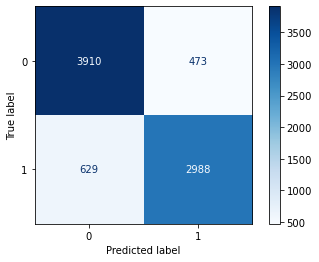

Gaussian Naive Bayes Test Data Confusion Matrix:



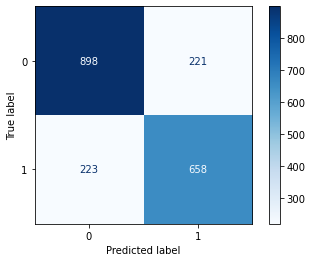

In [24]:
print('\033[1m' + 'Gaussian Naive Bayes Train Data Confusion Matrix:\n')
plot_confusion_matrix(gnb_grid, train10, y_train_lem10, cmap=plt.cm.Blues)
plt.show()
print('\033[1m' + 'Gaussian Naive Bayes Test Data Confusion Matrix:\n')
plot_confusion_matrix(gnb_grid, test10, y_test_lem10, cmap=plt.cm.Blues)
plt.show()

## Random Forest GridSearch 

In [26]:
rf_params = {'n_estimators': [100,200], 'criterion':['gini', 'entropy'],
           'oob_score':['True', 'False'], 'max_depth':[10,15,20]}

rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, scoring='f1_weighted',
                      return_train_score=True, verbose=1, n_jobs=-1)

rf_grid.fit(train10, y_train_lem10)

rf_grid_train_preds = rf_grid.predict(train10)
rf_grid_test_preds = rf_grid.predict(test10)

print('\033[1m' + 'Random Forest Classifier Train Report:\n' + '\033[0m')
print(classification_report(y_train_lem10, rf_grid_train_preds))
print('\033[1m' + 'Random Forest Classifier Test Report:\n' + '\033[0m')
print(classification_report(y_test_lem10, rf_grid_test_preds))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Random Forest Classifier Train Report:

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      4383
           1       0.96      0.44      0.61      3617

    accuracy                           0.74      8000
   macro avg       0.82      0.72      0.71      8000
weighted avg       0.81      0.74      0.72      8000

Random Forest Classifier Test Report:

              precision    recall  f1-score   support

           0       0.69      0.96      0.80      1119
           1       0.89      0.45      0.59       881

    accuracy                           0.73      2000
   macro avg       0.79      0.70      0.70      2000
weighted avg       0.77      0.73      0.71      2000



Random Forest Classifier Train Data Confusion Matrix:



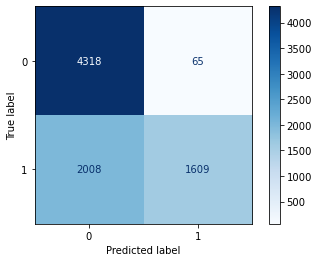

Random Forest Classifier Test Data Confusion Matrix:



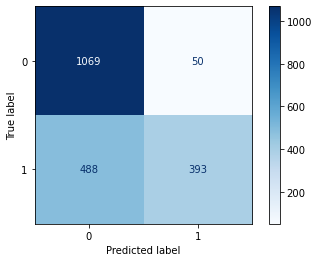

In [27]:
print('\033[1m' + 'Random Forest Classifier Train Data Confusion Matrix:\n')
plot_confusion_matrix(rf_grid, tfidf_data_train_lem10, y_train_lem10, cmap=plt.cm.Blues)
plt.show()
print('\033[1m' + 'Random Forest Classifier Test Data Confusion Matrix:\n')
plot_confusion_matrix(rf_grid, tfidf_data_test_lem10, y_test_lem10, cmap=plt.cm.Blues)
plt.show()